# MNIST Classification with a Simple Neural Network and Zigzag

In this notebook, we will implement a simple neural network to classify handwritten digits from the MNIST dataset using PyTorch. On top of it, we will apply the zigzag uncertainty approach and evaluate its uncertainty quality in terms of calibration and out-of-distribution detection.

In [1]:
import torch
import torchvision
import numpy as np

n_epochs = 5 # number of epochs for training
batch_size_train = 64 # batch size for training
batch_size_test = 640 # batch size for testing
learning_rate = 0.001 # learning rate for Adam
log_interval = 10 # logging interval for metrics

# fixing random seed
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

# Train / Test data loading

The MNIST dataset is a collection of handwritten digits commonly used for training and testing in the field of machine learning. It contains 70,000 grayscale images of handwritten digits, split into 60,000 training images and 10,000 test images. Each image is 28x28 pixels in size and represents a digit from 0 to 9.

In [5]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 8522396.71it/s] 


Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 623331.21it/s]


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 5568920.01it/s]


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4648738.11it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



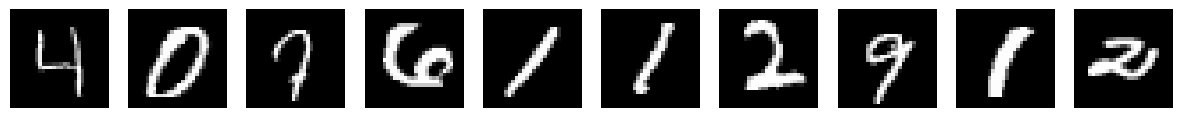

In [7]:
import matplotlib.pyplot as plt

images, targets = next(iter(train_loader))

# Number of images you want to display
num_images = 10

# Create a figure and a row of subplots
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

# Plot each image on a separate subplot
for i in range(num_images):
    axes[i].imshow(images[i, 0], cmap='gray')
    axes[i].axis('off')  # Hide axis

plt.show()

## NN Definition

We define a simple neural network model with several Conv2D layers followed by pooling layers and three fully connected layers. The input layer takes 28x28 MNIST images. The hidden layers have (320, 50) and (50, 50) units respectively, and the output layer has 10 units (one for each digit).

Original images have 1 channel for each of the pixels; therefore, for ZigZag, the first Conv2D layer takes 2 channels, where the second channel is either blank or an initial prediction, as described in the paper.


In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(2, 10, kernel_size=5) # modified first layer, takes 2-channel image as input
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 10)
        self.activation = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x, features=False):
        x = self.activation(F.max_pool2d(self.conv1(x), 2))
        x = self.activation(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x)

# Model Training

In [6]:
network = Net().cpu()
optimizer = optim.Adam(network.parameters(), lr=1e-3)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [14]:
# The constant used as "blank" for the additional dimension
# -20 is used as a value that is far from the class IDs
С = -20

def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):

    optimizer.zero_grad()

    # For further details, see Eq. 1 in https://openreview.net/pdf?id=QSvb6jBXML
    # The first input with an additional "blank" channel, the first term in Eq. 1
    inputs_1 = torch.cat([data, C * torch.ones_like(data)], dim=1).cpu()

    # The second input with actual targets, the second term in Eq. 1
    t_inputs = target.reshape(-1, 1, 1, 1) * torch.ones_like(data)
    inputs_2 = torch.cat([data, t_inputs], dim=1).cpu()

    # For simplicity, we randomly choose which inputs to use for computing the first or second terms
    # Could compute the whole Eq. 1 loss here instead
    p = 0.5
    mask = (torch.empty(inputs_1.shape[0], 1, 1, 1).uniform_(0, 1) > p).float().cpu()
    inputs = inputs_1 * mask + inputs_2 * (1 - mask)
    target = target

    output = network(inputs, features=False)

    loss = F.nll_loss(output, target.cpu())
    loss.backward()
    optimizer.step()

    loss = loss.cpu()

    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), '/vanilla_model.pth')
      torch.save(optimizer.state_dict(), '/vanilla_optimizer.pth')

def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      # Since we only evaluate accuracy, we only perform inference with the "blank" input
      inputs = torch.cat([data, С*torch.ones_like(data)], dim=1).cpu()
      output = network(inputs).cpu()
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  return 100 * correct / len(test_loader.dataset)

In [15]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-2-7d6a1feb5ac6>:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3075, Accuracy: 911/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303127
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.230019
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.159297
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.965385
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.820967
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.562164
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.482183
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.191792
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.900879
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.935195
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.523002
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.413025
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.417724
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.443372
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.663397
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.399820
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.343136
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.353270
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.396569
Train Epoch: 1 [12160/6

# Out-of-distribution Detection (FashionMNIST)

The FashionMNIST dataset serves as an out-of-distribution (OOD) dataset for the MNIST dataset, providing a more challenging and diverse set of images. While MNIST consists of 70,000 grayscale images of handwritten digits (0-9), FashionMNIST contains 70,000 grayscale images of various clothing items, including t-shirts, trousers, pullovers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots. Both datasets have the same structure, with 28x28 pixel images and 10 classes, making FashionMNIST a suitable alternative for evaluating models trained on MNIST. By using FashionMNIST as OOD data, we can assess the robustness our model when exposed to visually different, yet structurally similar, data.

In [16]:
train_fashion_loader = torch.utils.data.DataLoader(
  torchvision.datasets.FashionMNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_fashion_loader = torch.utils.data.DataLoader(
  torchvision.datasets.FashionMNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

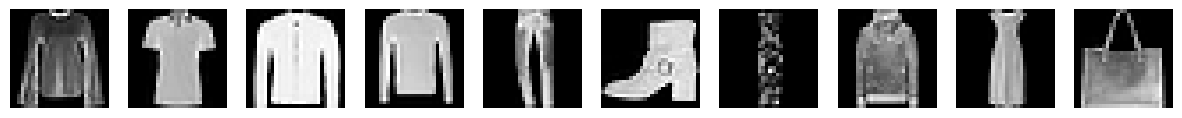

In [17]:
import matplotlib.pyplot as plt

images, targets = next(iter(test_fashion_loader))

# Number of images you want to display
num_images = 10

# Create a figure and a row of subplots
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

# Plot each image on a separate subplot
for i in range(num_images):
    axes[i].imshow(images[i, 0], cmap='gray')
    axes[i].axis('off')  # Hide axis

plt.show()

In [49]:
# Computing OOD metrics

network.eval()

uncertainties = np.array([])
labels = np.array([])
vectors = np.array([[]]).reshape([0, 10])
vectors_2 = np.array([[]]).reshape([0, 10])

C = -20

with torch.no_grad():
  for data, target in test_loader:

    # For further details, see Fig. 1 in https://openreview.net/pdf?id=QSvb6jBXML
    # The first inference with an additional "blank" channel, the top level in Fig. 1
    inputs = torch.cat([data, C*torch.ones_like(data)], dim=1).cpu()
    output = network(inputs)
    output = torch.softmax(output, dim=1)
    pred_target = torch.argmax(output, dim=1)

    # The second inference with added initial prediction, the bottom level in Fig. 1
    inputs = torch.cat([data.cpu(), pred_target.reshape(-1, 1, 1, 1) * torch.ones_like(data).cpu()], dim=1).cpu()
    output_w = network(inputs)
    output_w = torch.softmax(output_w, dim=1)
    pred_target = torch.argmax(output_w, dim=1)

    # Compute uncertainty as the difference between two predictions (see Eq. 3)
    uncertainty = torch.abs(output - output_w).mean(dim=1).cpu()

    # Save label for further AUC evaluation
    # In-distribution samples are assigned label 0
    label = np.zeros_like(uncertainty)

    uncertainties = np.concatenate([uncertainties, uncertainty])
    labels = np.concatenate([labels, label])

with torch.no_grad():
  for data, target in test_fashion_loader:

    # For further details, see Fig. 1 in https://openreview.net/pdf?id=QSvb6jBXML
    # The first inference with an additional "blank" channel, the top level in Fig. 1
    inputs = torch.cat([data, C*torch.ones_like(data)], dim=1).cpu()
    output = network(inputs)
    output = torch.softmax(output, dim=1)
    pred_target = torch.argmax(output, dim=1)

    # The second inference with added initial prediction, the bottom level in Fig. 1
    inputs = torch.cat([data.cpu(), pred_target.reshape(-1, 1, 1, 1) * torch.ones_like(data).cpu()], dim=1).cpu()
    output_w = network(inputs)
    output_w = torch.softmax(output_w, dim=1)
    pred_target = torch.argmax(output_w, dim=1)

    # Compute uncertainty as the difference between two predictions (see Eq. 3)
    uncertainty = torch.abs(output - output_w).mean(dim=1).cpu()

    # Save label for further AUC evaluation
    # Out-of-distribution samples are assigned label 1
    label = np.ones_like(uncertainty)

    uncertainties = np.concatenate([uncertainties, uncertainty])
    labels = np.concatenate([labels, label])

<ipython-input-2-7d6a1feb5ac6>:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


SINGLE MNIST ROC AUC: 0.98541304 PR AUC: 0.9834263154449212


In [56]:
import sklearn.metrics
roc_auc = sklearn.metrics.roc_auc_score(labels, uncertainties)
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(labels, uncertainties)
pr_auc = sklearn.metrics.auc(recall, precision)

# evaluate ROC- and PR-AUC metrics, see https://arxiv.org/abs/1802.10501 for more details
print(f"ROC AUC: {roc_auc:.4f} ")
print(f"PR AUC: {pr_auc:.4f}")

ROC AUC: 0.9854 
PR AUC: 0.9834


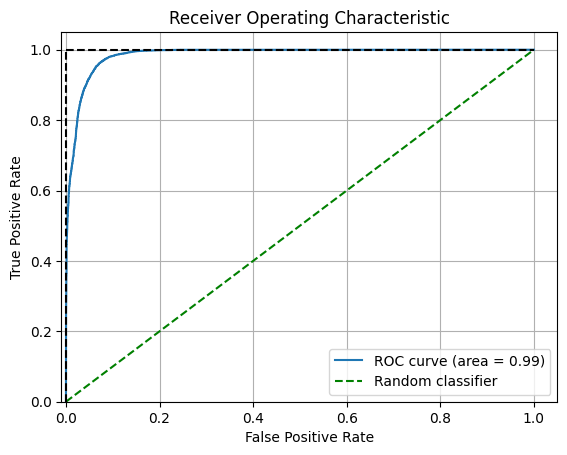

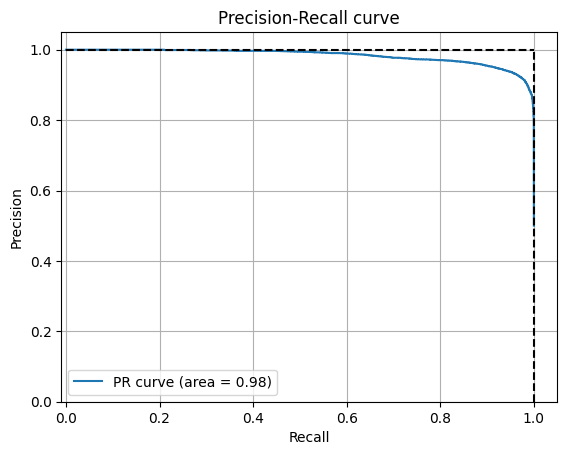

In [57]:
# Plot ROC curve
fpr, tpr, _ = sklearn.metrics.roc_curve(labels, uncertainties)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'g--', label="Random classifier")
plt.hlines(1, xmin=0, xmax=1, color='k', linestyle="--")
plt.vlines(0, ymin=0, ymax=1, color='k', linestyle="--")
plt.xlim([-0.01, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.grid()
plt.legend(loc="lower right")
plt.show()

# Plot PR curve
plt.figure()
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.hlines(1, xmin=0, xmax=1, color='k', linestyle="--")
plt.vlines(1, ymin=0, ymax=1, color='k', linestyle="--")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.xlim([-0.01, 1.05])
plt.ylim([0.0, 1.05])
plt.grid()
plt.legend(loc="lower left")
plt.show()


# Uncertainty Calibration Evaluation

For calibration evaluation, we use the rAULC metric. For more details, see https://arxiv.org/pdf/2107.00649.

In [67]:
network.eval()

uncertainties = np.array([])
labels = np.array([])

C = -20

with torch.no_grad():
  for data, target in test_loader:

    # The first inference with an additional "blank" channel, the top level in Fig. 1
    inputs = torch.cat([data, C*torch.ones_like(data)], dim=1).cpu()
    output = network(inputs)

    pred_target = torch.argmax(output, dim=1)

     # The second inference with added initial prediction, the bottom level in Fig. 1
    inputs = torch.cat([data.cpu(), pred_target.reshape(-1, 1, 1, 1) * torch.ones_like(data).cpu()], dim=1).cpu()
    output_w = network(inputs, features=True)

    # Compute uncertainty as the difference between two predictions (see Eq. 3)
    uncertainty = torch.abs(torch.nn.functional.softmax(output) - torch.nn.functional.softmax(output_w)).mean(dim=1).detach().cpu()
    label = (pred_target.cpu() == target).cpu()

    uncertainties = np.concatenate([uncertainties, uncertainty])
    labels = np.concatenate([labels, label])

<ipython-input-2-7d6a1feb5ac6>:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
<ipython-input-67-d0e444181f5f>:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  uncertainty = torch.abs(torch.nn.functional.softmax(output) - torch.nn.functional.softmax(output_w)).mean(dim=1).detach().cpu()


0.01572216813102867 0.015019794841701906
0.9553259268395313


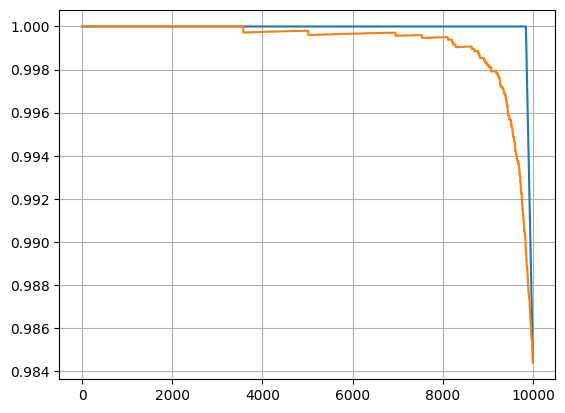

In [65]:
import numpy as np

def AULC(accs, uncertainties):
  idxs = np.argsort(uncertainties)
  uncs_s = uncertainties[idxs]
  error_s = accs[idxs]

  mean_error = error_s.mean()
  error_csum = np.cumsum(error_s)

  Fs = error_csum / np.arange(1, len(error_s) + 1)
  s = 1 / len(Fs)
  return -1 + s * Fs.sum() / mean_error, Fs

def rAULC(uncertainties, accs):
    perf_aulc, Fsp = AULC(accs, -accs.astype("float"))
    curr_aulc, Fsc = AULC(accs, uncertainties)
    print(perf_aulc, curr_aulc)
    return curr_aulc / perf_aulc, Fsp, Fsc

res, r1, r2 = rAULC(uncertainties, labels)
print(res)

import matplotlib.pyplot as plt
plt.plot(range(len(r1)), r1)
plt.plot(range(len(r1)), r2)
plt.grid()